First divion of CNN in stem, body and head.
- Stem: first 2/3 convs (low lev features)
- body: internal convs
- head: map to out features

This model concatenate multy brach conv without the problem to chose wich is the best kernel size 

In [4]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
from torch import nn
from torch.nn import functional as F
import torch

Cloning into 'Learning'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 71 (delta 23), reused 59 (delta 17), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [5]:
train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

60000 10000 375 94 79


In [7]:
class Inception(nn.Module):
    # ci are the out_channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # branch 1 
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, X):
        b1 = F.relu(self.b1_1(X))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(X))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(X))))
        b4 = F.relu(self.b4_2(self.b4_1(X)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogLeNet(FFL.Classifier):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), 
                                 self.b4(), self.b5(), nn.LazyLinear(num_classes))
        
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1),
            nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b3(self):
        return nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
    def b4(self):
        return nn.Sequential(
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 32),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b5(self):
        return nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
        )

    

The first thing we need to realise is that F.relu doesn’t return a hidden layer. Rather, it activates the hidden layer that comes before it. F.relu is a function that simply takes an output tensor as an input, converts all values that are less than 0 in that tensor to zero, and spits this out as an output.

nn.ReLU does the exact same thing, except that it represents this operation in a different way, requiring us to first initialise the method with nn.ReLU, before using it in the forward call. In fact, nn.ReLU itself encapsulates F.relu

In [8]:
model, loss_f = FFL.get_model(GoogLeNet(), (1, 1, 96, 96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


X output shape:	 torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])

Number of parameters: 5949850


In [9]:
train_loss, val_loss, acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.01, epochs=10)

Epoch: 0, loss = 2.301641731262207, v_loss = 2.3001963914708887, accuracy = 0.1002769023180008
Epoch: 1, loss = 2.298348699569702, v_loss = 2.2956617030691593, accuracy = 0.15021756291389465
Epoch: 2, loss = 2.2884223232269285, v_loss = 2.2732573595452816, accuracy = 0.32407042384147644
Epoch: 3, loss = 2.1352452551523844, v_loss = 1.6413050052967477, accuracy = 0.4156447649002075
Epoch: 4, loss = 1.3428056740760803, v_loss = 0.8765797856006217, accuracy = 0.6766218543052673
Epoch: 5, loss = 0.8152935883204142, v_loss = 0.6370762485138913, accuracy = 0.7542523741722107
Epoch: 6, loss = 0.6490809280872345, v_loss = 0.5456316832532274, accuracy = 0.7860957384109497
Epoch: 7, loss = 0.5624832767645518, v_loss = 0.4879778712353808, accuracy = 0.8035996556282043
Epoch: 8, loss = 0.5047550466855367, v_loss = 0.4464042139180163, accuracy = 0.8194224834442139
Epoch: 9, loss = 0.4643899635473887, v_loss = 0.41640317535146754, accuracy = 0.8316851258277893


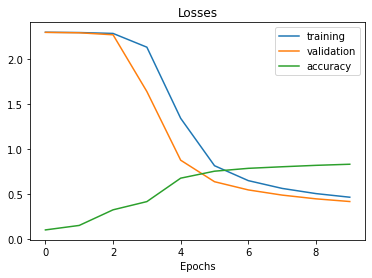

prediction comparison:

 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  Tr

In [14]:
FFL.after_training_plots(train_loss, val_loss, acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/GoogLeNet_trained.pt")
#model.load_state_dict(FFL.torch.load("/content/Learning/GoogLeNet_trained.pt"))